In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# 定义一个新的CNN模型
class CustomCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),                                 # 我們也有通過Batch Normalization來解決梯度爆炸或消失的問題
            nn.ReLU(inplace=True),                              # 我們跑一次模型的執行時間相當久，在我們資料集這麼多張照片的情況下選ReLU能讓整個訓練比較快，嘗試其他Activation Function後，也覺得ReLU的表現很出色
            nn.MaxPool2d(kernel_size=2, stride=2),              # MaxPooling因為我們的圖片背景可能比較多noise，所以認為用MaxPooling比較可以抑制這些noise的影響
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [2]:
# 设置超参数
batch_size = 64
learning_rate = 0.001
num_epochs = 20

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
dataset = datasets.ImageFolder(root='./data', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# 定义模型、损失函数和优化器
model = CustomCNN(num_classes=len(dataset.classes)).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)                #自己調整學習率，不會過度快速收斂

In [4]:
# 训练模型
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    # 验证模型
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/20], Loss: 1.1172
Validation Loss: 0.6674, Accuracy: 78.52%
Epoch [2/20], Loss: 0.6144
Validation Loss: 0.6541, Accuracy: 78.71%
Epoch [3/20], Loss: 0.6030
Validation Loss: 0.6683, Accuracy: 79.09%
Epoch [4/20], Loss: 0.5840
Validation Loss: 0.6518, Accuracy: 78.90%
Epoch [5/20], Loss: 0.5946
Validation Loss: 0.6427, Accuracy: 79.28%
Epoch [6/20], Loss: 0.5839
Validation Loss: 0.6558, Accuracy: 80.04%
Epoch [7/20], Loss: 0.5775
Validation Loss: 0.6508, Accuracy: 78.90%
Epoch [8/20], Loss: 0.5721
Validation Loss: 0.6483, Accuracy: 79.85%
Epoch [9/20], Loss: 0.5764
Validation Loss: 0.6579, Accuracy: 80.23%
Epoch [10/20], Loss: 0.5728
Validation Loss: 0.6541, Accuracy: 79.85%
Epoch [11/20], Loss: 0.5540
Validation Loss: 0.6745, Accuracy: 80.23%
Epoch [12/20], Loss: 0.5474
Validation Loss: 0.6763, Accuracy: 79.28%
Epoch [13/20], Loss: 0.5508
Validation Loss: 0.6618, Accuracy: 79.85%
Epoch [14/20], Loss: 0.5428
Validation Loss: 0.6698, Accuracy: 79.28%
Epoch [15/20], Loss: 0.5511
V

In [5]:
# 测试模型
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Test Loss: 0.5163, Accuracy: 83.11%


F1 Score: 0.4278, Recall: 0.4036, Precision: 0.6870


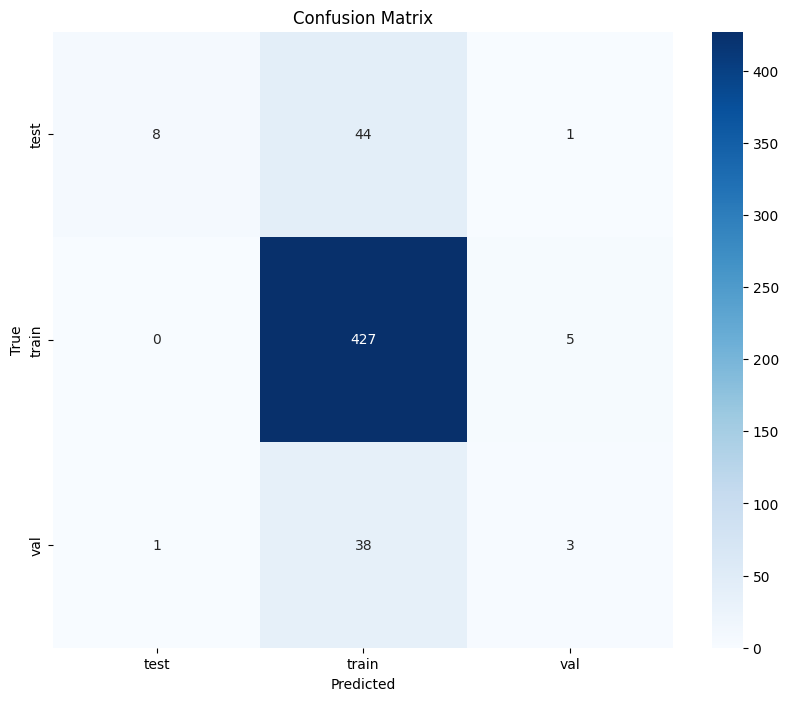

In [6]:
# 计算F1 score, recall, precision
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')

print(f'F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')